In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import openpyxl

import re

from datetime import timedelta

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [2]:
# Загрузка данных
file_path = "C:/Python/Korova/mastities_analytic_v2.xlsx"  
df = pd.read_excel(file_path)

In [3]:
# Удаление строк, содержащих "Unknown" (без учета регистра и пробелов)
df = df[~df["DescriptionReport"].str.contains(r"\bUnknown\b", case=False, na=False)]

In [4]:
df

,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName
0,8036,Пташка,Ч/п голштинская-,4,2013-12-27 00:00:00,2009-07-24,Кл.маст. Кобакт,Абсцесс 30 d 1X1ml,Admin
1,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
2,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
3,103602,Нота,Ч/п голштинская,5,2016-02-24 00:00:00,2011-02-16,Гнойный абсцесс доли,Абсцесс 30 d 1X1ml,Admin
4,992,Абрикоса,Ч/п голштинская-,7,2012-09-02 00:00:00,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
...,...,...,...,...,...,...,...,...,...
11002,22824,Волга,Ч/п голштинская,1,2024-10-18 16:00:00,2022-07-13,Клинический мастит,"Тиломаст 3 d 1X1pcs Интрацистернально, Моксифо...",Семыкин А.К.
11003,20974,Горная,Ч/п голштинская,3,2024-10-20 14:00:00,2020-09-08,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11004,21822,Белка,Ч/п голштинская,2,2024-10-20 14:00:00,2021-07-23,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11005,171004,Опора,Jersey,5,2024-10-20 14:00:00,2017-11-13,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.


**Создаем словарь отдельным столбцом {схема лечения: доза,..}**

In [5]:
# Функция для извлечения действующих веществ и доз
def parse_multiple_descriptions(description):
    try:
        # Разделяем описание на отдельные препараты
        substances = re.split(r',\s*', description)
        result = {}
        
        # Обрабатываем каждый препарат
        for substance in substances:
            parts = substance.split()  # Разделяем по пробелам
            active_substance = parts[0]  # Первое слово — действующее вещество
            dose = next((p for p in parts if 'X' in p), None)  # Находим дозировку
            if dose:
                result[active_substance] = dose
        
        return result
    except Exception as e:
        return {"Ошибка": str(e)}

# Применение функции к столбцу DescriptionReport
df["ParsedReport"] = df["DescriptionReport"].apply(parse_multiple_descriptions)

# Вывод результата
df

,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName,ParsedReport
0,8036,Пташка,Ч/п голштинская-,4,2013-12-27 00:00:00,2009-07-24,Кл.маст. Кобакт,Абсцесс 30 d 1X1ml,Admin,{'Абсцесс': '1X1ml'}
1,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,{'Суб.клиника': '1X1ml'}
2,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,{'Суб.клиника': '1X1ml'}
3,103602,Нота,Ч/п голштинская,5,2016-02-24 00:00:00,2011-02-16,Гнойный абсцесс доли,Абсцесс 30 d 1X1ml,Admin,{'Абсцесс': '1X1ml'}
4,992,Абрикоса,Ч/п голштинская-,7,2012-09-02 00:00:00,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,{'Суб.клиника': '1X1ml'}
...,...,...,...,...,...,...,...,...,...,...
11002,22824,Волга,Ч/п голштинская,1,2024-10-18 16:00:00,2022-07-13,Клинический мастит,"Тиломаст 3 d 1X1pcs Интрацистернально, Моксифо...",Семыкин А.К.,"{'Тиломаст': '1X1pcs', 'Моксифорт': '1X60ml', ..."
11003,20974,Горная,Ч/п голштинская,3,2024-10-20 14:00:00,2020-09-08,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ..."
11004,21822,Белка,Ч/п голштинская,2,2024-10-20 14:00:00,2021-07-23,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ..."
11005,171004,Опора,Jersey,5,2024-10-20 14:00:00,2017-11-13,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ..."


**Анализ эффективности и зависимости**

In [6]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)

        for i, row in group.iterrows():
            # Пропустить записи, где уже указано "здоров" (без учета регистра)
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка эффективности
            effective = any("здоров" in x.lower() for x in follow_up["DiagName"])
            ineffective = any("здоров" not in x.lower() for x in follow_up["DiagName"])

            # Если эффективное лечение найдено и нет признаков рецидива
            is_effective = effective and not ineffective

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": is_effective
            })

    return pd.DataFrame(results)

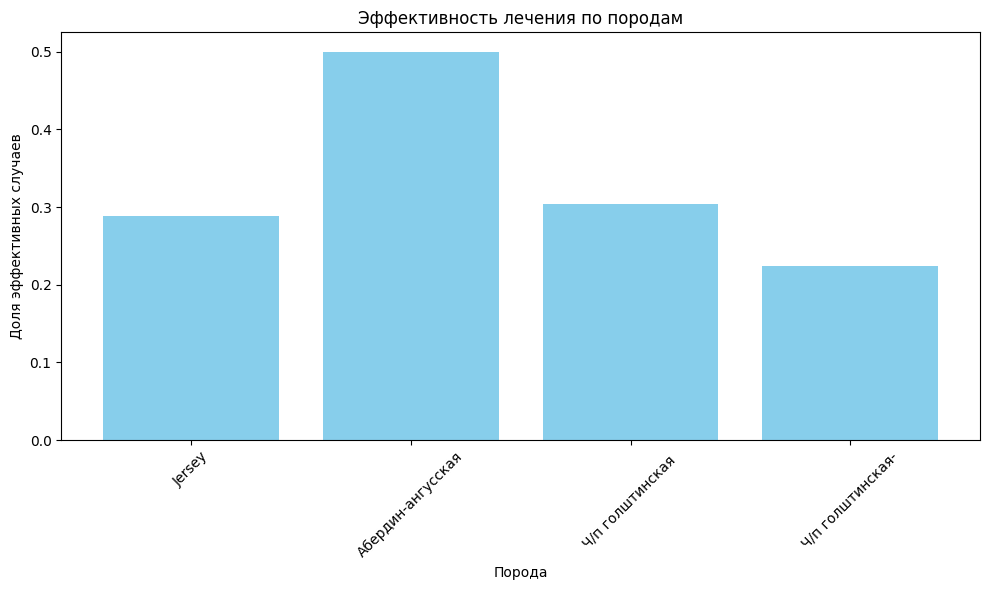

In [7]:
# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по породам
    breed_effectiveness = effectiveness_df.groupby("breed")["Effective"].mean().reset_index()

    # Группировка по числу отелов
    lactation_effectiveness = effectiveness_df.groupby("LactationNumber")["Effective"].mean().reset_index()

    # Визуализация эффективности по породам
    plt.figure(figsize=(10, 6))
    plt.bar(breed_effectiveness["breed"], breed_effectiveness["Effective"], color="skyblue")
    plt.title("Эффективность лечения по породам")
    plt.xlabel("Порода")
    plt.ylabel("Доля эффективных случаев")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Вывод:**<br/>
Эффективнсть лечения по породам, без учета доли каждой породы в общем количестве всей выборки. Наибольшую эффективнось лечения показала порода "Абердин-ангусская". 
Наименьшуж эффективность показала порода "Ч/п голшинская-".

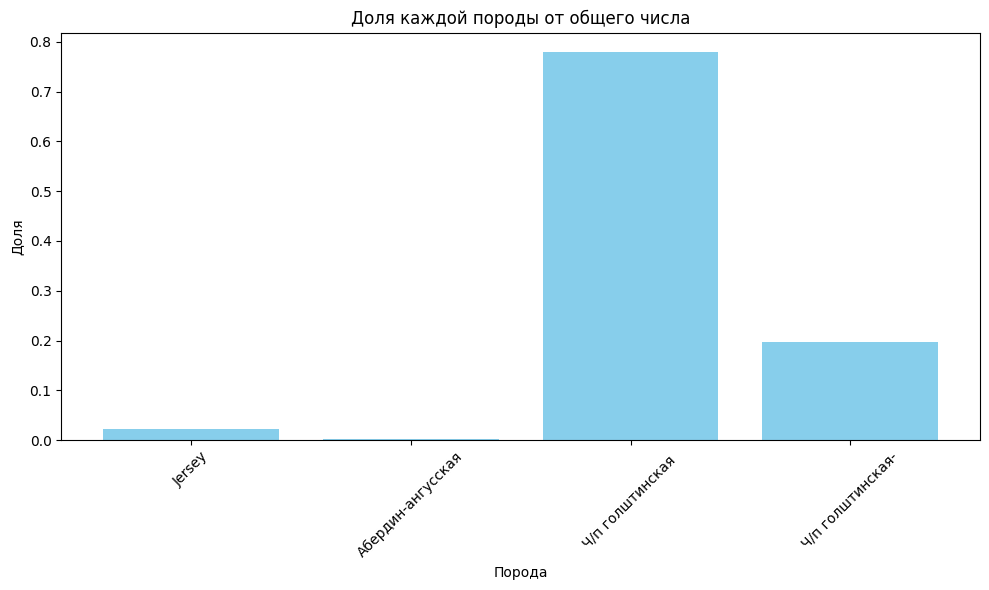

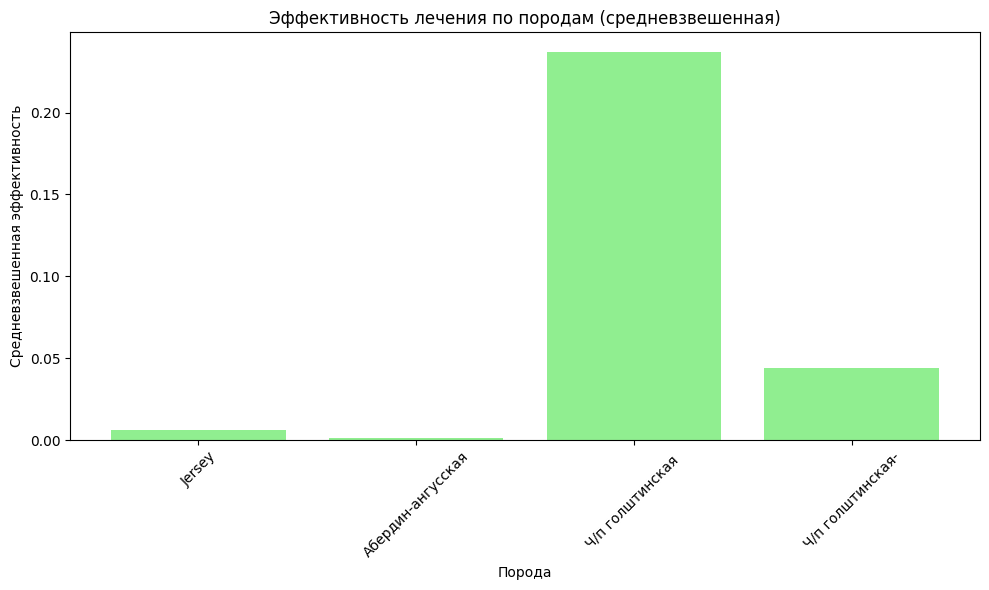

In [8]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)

        for i, row in group.iterrows():
            # Пропускаем, если запись уже содержит "Здоров" без учета регистра
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]

            # Проверка эффективности
            effective = (
                any("здоров" in x.lower() for x in follow_up["DiagName"]) and  # Лечение успешно
                not any("здоров" not in x.lower() and x.strip() for x in follow_up["DiagName"])  # Нет нового диагноза
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": effective
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness(df, days_after_treatment)

if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по породам
    breed_effectiveness = effectiveness_df.groupby("breed")["Effective"].mean().reset_index()

    # Считаем количество коров каждой породы
    breed_counts = df.groupby("breed")["number"].nunique().reset_index(name="Count")

    # Средневзвешенная эффективность
    breed_effectiveness = breed_effectiveness.merge(breed_counts, on="breed")
    breed_effectiveness["WeightedEffectiveness"] = breed_effectiveness["Effective"] * breed_effectiveness["Count"]

    # Доли пород
    breed_counts["Proportion"] = breed_counts["Count"] / breed_counts["Count"].sum()

    # Визуализация долей пород
    plt.figure(figsize=(10, 6))
    plt.bar(breed_counts["breed"], breed_counts["Proportion"], color="skyblue")
    plt.title("Доля каждой породы от общего числа")
    plt.xlabel("Порода")
    plt.ylabel("Доля")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Визуализация эффективности лечения по породам (средневзвешенной)
    breed_effectiveness["ProportionEffectiveness"] = breed_effectiveness["WeightedEffectiveness"] / breed_effectiveness["Count"].sum()

    plt.figure(figsize=(10, 6))
    plt.bar(breed_effectiveness["breed"], breed_effectiveness["ProportionEffectiveness"], color="lightgreen")
    plt.title("Эффективность лечения по породам (средневзвешенная)")
    plt.xlabel("Порода")
    plt.ylabel("Средневзвешенная эффективность")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Вывод:**<br/>
Доля каждой породы от общего чиста: самая большая доля: "Ч/п голштинская". Самая наименьшая доля: "Абердин-ангусская".<br/>
Эффективность лечения по породам (средневзвешенная): Наибольшую средневзвешенную эффективность лечения показала порода "Ч/п голштинская".<br/>

**Анализ неэффективного лечения по числу отелов и количеству предыдущих диагнозов**

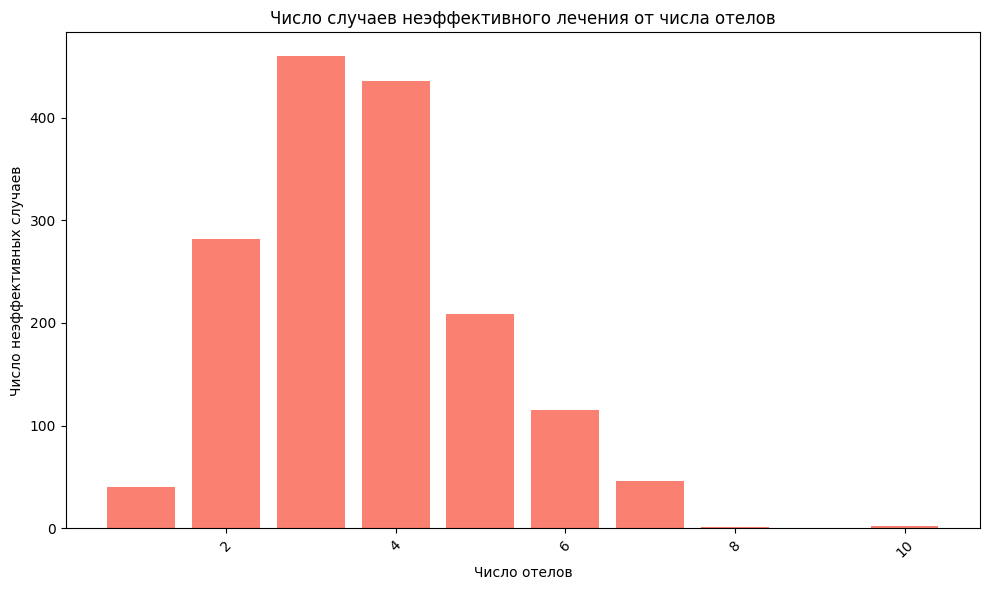

In [9]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness_with_previous_diagnoses(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)
        
        previous_healthy_cases = 0  # Счетчик записей, где корова была здорова

        for i, row in group.iterrows():
            # Подсчет предыдущих "здоровых" записей
            previous_healthy_cases += int("здоров" in row["DiagName"].lower())

            # Пропустить записи, где уже указано "здоров" (без учета регистра)
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка неэффективности: нет "здоров" в follow_up или есть другой диагноз
            ineffective = (
                not any("здоров" in x.lower() for x in follow_up["DiagName"]) and
                len(follow_up) > 0
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": not ineffective,
                "PreviousHealthyCases": previous_healthy_cases
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness_with_previous_diagnoses(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по числу отелов
    lactation_ineffective = effectiveness_df[~effectiveness_df["Effective"]].groupby("LactationNumber").size().reset_index(name="IneffectiveCount")

    # Группировка по количеству предыдущих диагнозов
    previous_healthy_ineffective = effectiveness_df[~effectiveness_df["Effective"]].groupby("PreviousHealthyCases").size().reset_index(name="IneffectiveCount")

    # Визуализация зависимости неэффективности от числа отелов
    plt.figure(figsize=(10, 6))
    plt.bar(lactation_ineffective["LactationNumber"], lactation_ineffective["IneffectiveCount"], color="salmon")
    plt.title("Число случаев неэффективного лечения от числа отелов")
    plt.xlabel("Число отелов")
    plt.ylabel("Число неэффективных случаев")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Вывод:** <br/>
Число случаев неэффективного лечения растет с число отелов линейно до 3 отела, потом экспоненциально падает. Падение возможно со сниженем также чила отелов после 3. 

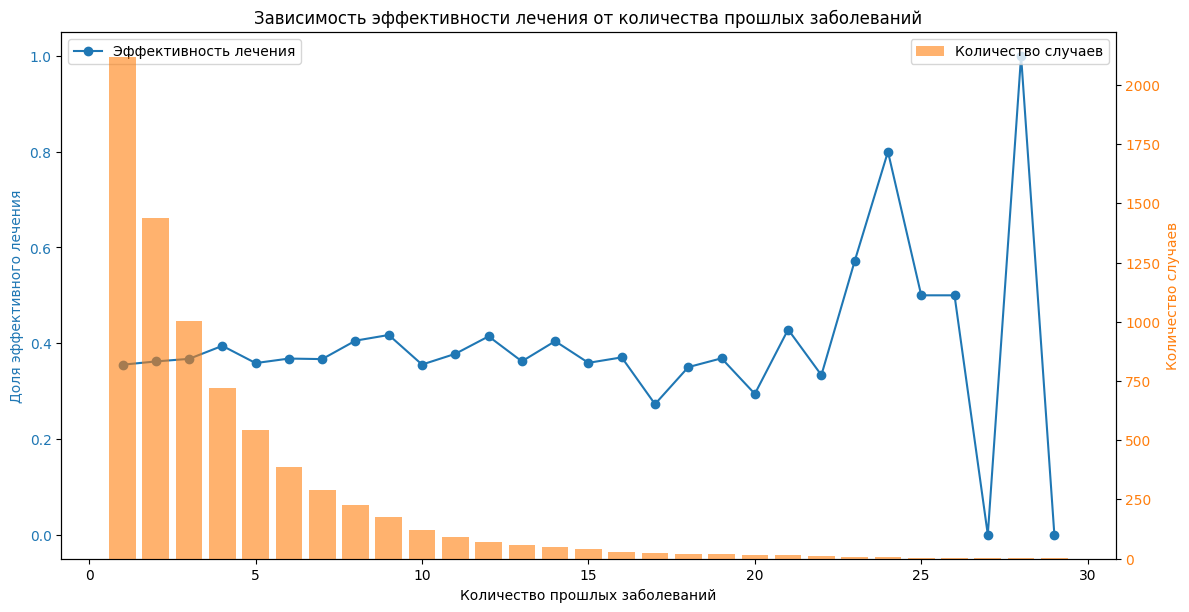

In [10]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness_with_past_illnesses(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)
        
        past_illnesses = 0  # Счетчик заболеваний (записей без "здоров")

        for i, row in group.iterrows():
            # Подсчет количества прошлых заболеваний
            if not ("здоров" in row["DiagName"].lower()):
                past_illnesses += 1

            # Пропустить записи, где уже указано "здоров" (без учета регистра)
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка эффективности
            effective = any("здоров" in x.lower() for x in follow_up["DiagName"]) and not (
                len(follow_up) > 0 and not any("здоров" in x.lower() for x in follow_up["DiagName"])
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": effective,
                "PastIllnesses": past_illnesses
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness_with_past_illnesses(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по количеству прошлых заболеваний
    past_illness_effectiveness = effectiveness_df.groupby("PastIllnesses")["Effective"].mean().reset_index()
    past_illness_counts = effectiveness_df["PastIllnesses"].value_counts().reset_index()
    past_illness_counts.columns = ["PastIllnesses", "Count"]

    # Визуализация зависимости эффективности от количества прошлых заболеваний
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel("Количество прошлых заболеваний")
    ax1.set_ylabel("Доля эффективного лечения", color=color)
    ax1.plot(
        past_illness_effectiveness["PastIllnesses"],
        past_illness_effectiveness["Effective"],
        color=color,
        marker="o",
        label="Эффективность лечения"
    )
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()  # Вторая ось для количества случаев
    color = 'tab:orange'
    ax2.set_ylabel("Количество случаев", color=color)
    ax2.bar(
        past_illness_counts["PastIllnesses"],
        past_illness_counts["Count"],
        alpha=0.6,
        color=color,
        label="Количество случаев"
    )
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc="upper right")

    fig.tight_layout()
    plt.title("Зависимость эффективности лечения от количества прошлых заболеваний")
    plt.show()


**Вывод:** <br/>
Для всех пород эффективность лечения экпоненциально падает с ростом количества прошлых заболеваний. 

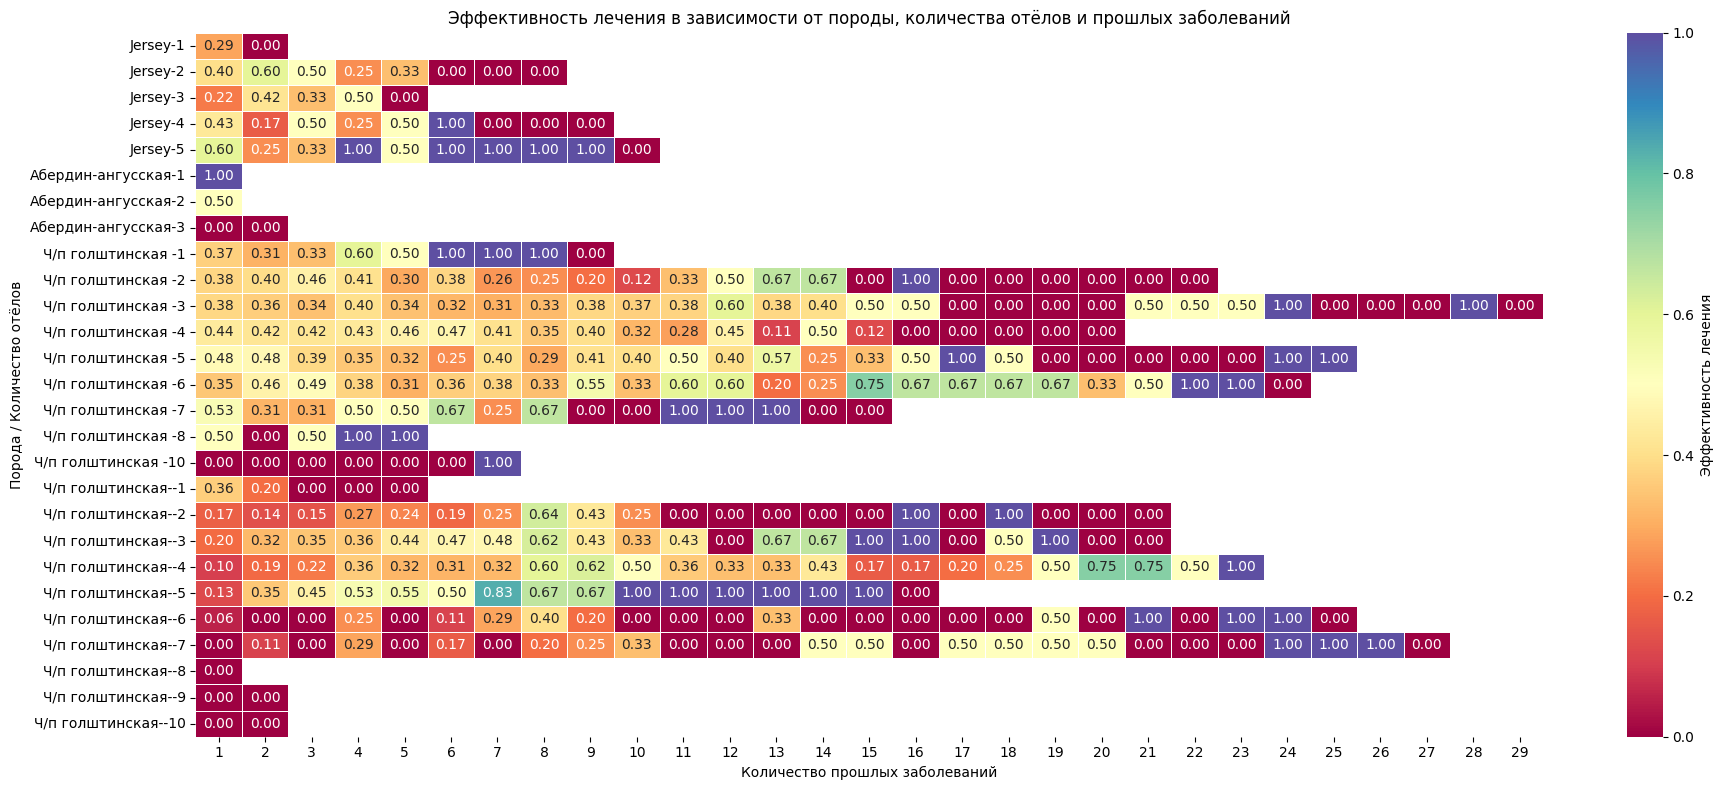

In [11]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

# Функция для анализа эффективности с учетом трех факторов
def analyze_effectiveness_with_factors(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)
        
        past_illnesses = 0  # Счетчик заболеваний (записей без "здоров")

        for i, row in group.iterrows():
            # Подсчет количества прошлых заболеваний
            if not ("здоров" in row["DiagName"].lower()):
                past_illnesses += 1

            # Пропустить записи, где уже указано "здоров"
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка эффективности
            effective = any("здоров" in x.lower() for x in follow_up["DiagName"]) and not (
                len(follow_up) > 0 and not any("здоров" in x.lower() for x in follow_up["DiagName"])
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": effective,
                "PastIllnesses": past_illnesses
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_effectiveness_with_factors(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по породе, количеству отёлов и прошлых заболеваниям
    grouped = effectiveness_df.groupby(["breed", "LactationNumber", "PastIllnesses"])["Effective"].mean().reset_index()

    # Визуализация зависимости
    pivot_table = grouped.pivot_table(
        index=["breed", "LactationNumber"], 
        columns="PastIllnesses", 
        values="Effective", 
        aggfunc="sum"
    )

    plt.figure(figsize=(19, 8))
    sns.heatmap(
        pivot_table, 
        cmap="Spectral", 
        annot=True, 
        fmt=".2f", 
        linewidths=0.5, 
        cbar_kws={'label': 'Эффективность лечения'}
    )
    plt.title("Эффективность лечения в зависимости от породы, количества отёлов и прошлых заболеваний")
    plt.xlabel("Количество прошлых заболеваний")
    plt.ylabel("Порода / Количество отёлов")
    plt.tight_layout()
    plt.show()

Для породы "Jersey" эффективность лечения падает после 6 раза заболевания (постанови диагноза). <br/>
Для породы "Ч/п Голштинская" эффективность лечения падает с ростом количества отелов: начиная с 7 отела резко падает эффективность дечения. Для этой породы с 10 отела дечение оказывается неэффективным независимо от 
количества предыдущих диагнзов.<br/>
Для породы "Ч/п Голштинская" эффективность лечения падает с ростом количества количества прощлых заболеваний: начиная с постновки 11 диагноза начинается резкий спад эффективноси лечения. <br/>
Порода "Голштинская-" менее устойчива к схемам лечения, начиная с первого отела и независимо от количества предыдущих заболевамний, относительно других пород, где явно прослеживается зависимость <br/>
эффективности лечения от количества отелов и количества предшествующих диагнозов.<br/>


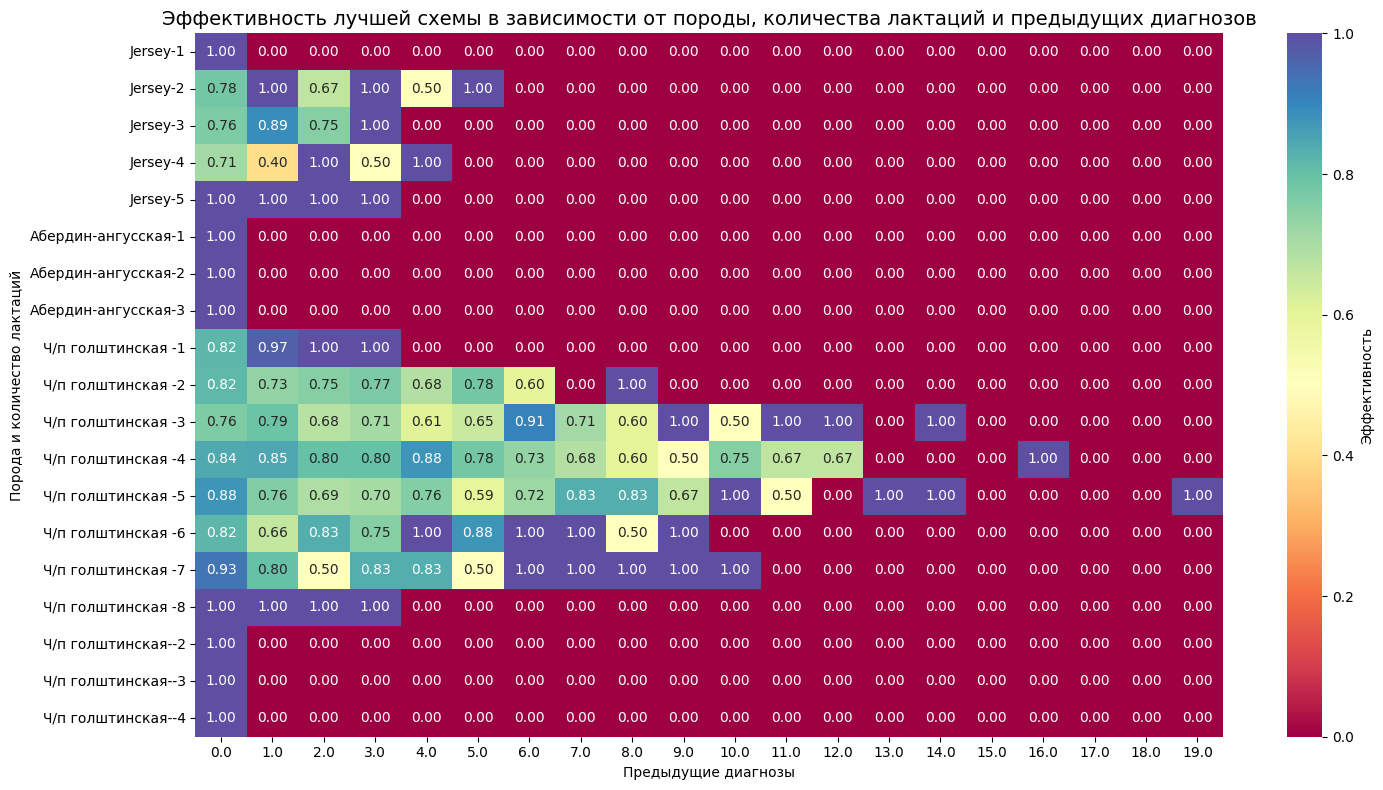

In [12]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Мастимакс", "Мастисепт", "Милоклокс"]

# --- Шаг 1: Отфильтровать данные по схеме лечения ---
# Замените `df` на ваш DataFrame
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)

filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Добавить столбец количества предыдущих диагнозов ---
filtered_data["PreviousDiagnoses"] = filtered_data.groupby("number")["DateAndTime"].rank(method="first") - 1

# --- Шаг 3: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 4: Создать сводную таблицу ---
pivot_data = filtered_data.pivot_table(
    values="Effective",
    index=["breed", "LactationNumber"],
    columns="PreviousDiagnoses",
    aggfunc="mean"
).fillna(0)

# --- Шаг 5: Построить тепловую карту ---
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
plt.title("Эффективность лучшей схемы в зависимости от породы, количества лактаций и предыдущих диагнозов", fontsize=14)
plt.xlabel("Предыдущие диагнозы")
plt.ylabel("Порода и количество лактаций")
plt.tight_layout()
plt.show()

**Вывод:**<br/>
Эффективность лучшей схемы лечения в зависимости от породы, количества лактаций и предыдущих диагнозов показывает, что  породы "Ч/п Голштинская" с 1 по 7 отел работает очень эффективно, 1 первого по 12 раз постановки диагноза. 
Также для породы "Jersey" схема работает очень эффективно  с 1 по 5 отел и с 1 по 3 раз постановки диагноза. Для породы "Ч/п Голштинская-" схема работает эффективно только, если корова болеет 1-й раз. 
Вывод: наиоучшая схема наиболее эффективна для породы: "Ч/п Голштинская".

**Успешные схемы лечения для каждой породы**

In [13]:
# Установка интервала выздоровления в днях
success_days = 10  # По умолчанию 14 дней

# Сортировка данных по ID коровы и времени записи
df = df.sort_values(by=['number', 'DateAndTime'])

# Добавление флага выздоровления (если диагноз == 'здоров')
df['IsHealthy'] = df['DiagName'].str.contains('здоров', case=False, na=False)

# Анализ успешности лечения
success_counts = {}  # Словарь для хранения успешности схем лечения

for cow_id, group in df.groupby('number'):
    prev_treatment = None
    for i, row in group.iterrows():
        if row['IsHealthy']:
            # Если диагноз "здоров", предыдущая схема лечения успешна
            if prev_treatment:
                success_counts[prev_treatment] = success_counts.get(prev_treatment, 0) + 1
            prev_treatment = None  # Сбрасываем текущую схему лечения
        else:
            # Запоминаем текущую схему лечения
            prev_treatment = (row['breed'], row['DescriptionReport'])

# Сортировка схем лечения по успешности для каждой породы
breed_success = {}
for (breed, treatment), count in success_counts.items():
    if breed not in breed_success:
        breed_success[breed] = []
    breed_success[breed].append((treatment, count))

# Сортируем схемы лечения внутри каждой породы по убыванию успешности
for breed in breed_success:
    breed_success[breed].sort(key=lambda x: x[1], reverse=True)

# Вывод результатов
for breed, treatments in breed_success.items():
    print(f"\nПорода: {breed}")
    print("Лучшие схемы лечения (в порядке убывания успешности):")
    for treatment, count in treatments[:5]:  # Выводим максимум 5 схем лечения
        print(f"- {treatment} (Успешные случаи: {count})")
    if len(treatments) > 5:
        print(f"И еще {len(treatments) - 5} схем(ы) лечения...")
    elif not treatments:
        print("Нет успешных схем лечения для данной породы.")        


Порода: Ч/п голштинская-
Лучшие схемы лечения (в порядке убывания успешности):
- Нитокс 1 d 1X60ml Внутримышечно, Мастиет форте 1 d 1X2pcs Интрацистернально, Айнил 3 d 1X30ml Внутримышечно, Гентаприм 5 d 1X60ml Внутримышечно (Успешные случаи: 92)
- Нитокс 1 d 1X60ml Intramuscular, Мастиет форте 1 d 1X2pcs Intramammary, Айнил 3 d 1X30ml Intramuscular, Гентаприм 5 d 1X60ml Intramuscular (Успешные случаи: 84)
- Алезан гель 3 d 1X50gm (Другие), Амоксицилин 15% 1 d 1X60ml Внутримышечно, Байтрил МАХ 1 d 1X60ml Внутривенно, Мультибай 5 d 1X2pcs Интрацистернально (Успешные случаи: 75)
- Алезан гель 3 d 1X50gm (Other), Амоксицилин 15% 1 d 1X60ml Intramuscular, Байтрил МАХ 1 d 1X60ml Intravenous, Мультибай 5 d 1X2pcs Intramammary (Успешные случаи: 45)
- Байоклав 5 d 1X10ml Интрацистернально, Амоксицилин 15% 2 d 2X60ml Внутримышечно, НПВС 5 d 1X25ml Внутримышечно, Гентаприм 5 d 1X60ml Внутримышечно (Успешные случаи: 39)
И еще 40 схем(ы) лечения...

Порода: Ч/п голштинская 
Лучшие схемы лечения (

Значение в скобках (Успешность: 1) при выводе результата указывает на количество успешных случаев применения данной схемы лечения для конкретной породы. Это число показывает, сколько раз схема лечения привела к выздоровлению коров данной породы в вашей базе данных


**Вывод**<br/>
Для пород: Ч/п голштинская и Jersey лучшие схемы лечения совпадают. Для породы Ч/п голштинская лучшая схема лечения отличается от лучших схем лечения для пород: Ч/п голштинская и Jersey. Это было видно из предыдущей тепловой карты. Теперь пордтвеждаем предположение подсчетом.

**Сравнение успешности различных схем лечения для одной породы**

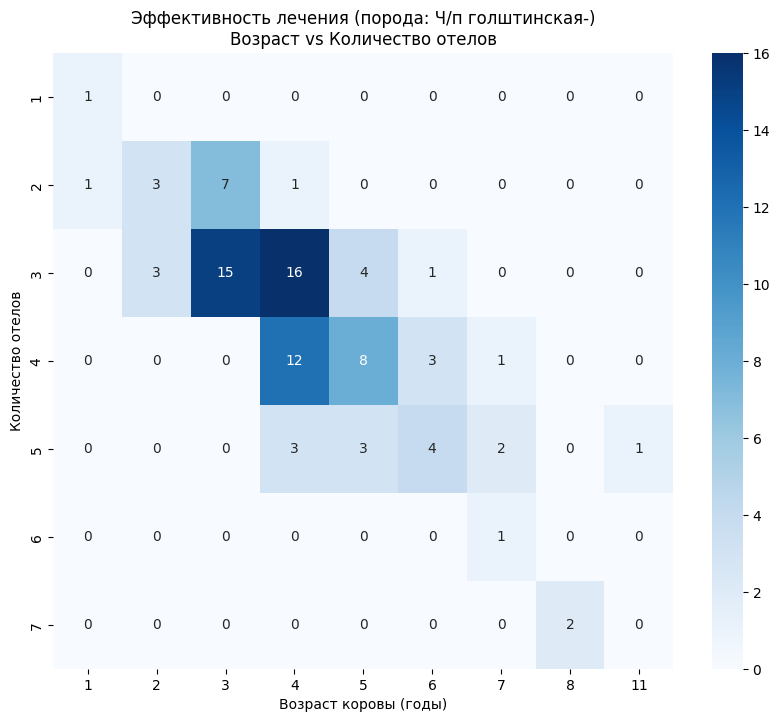

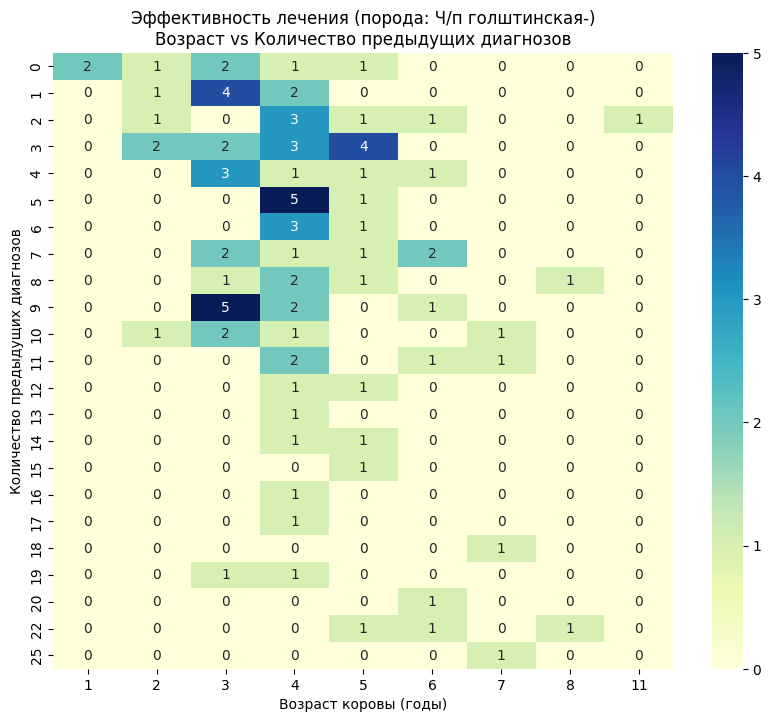

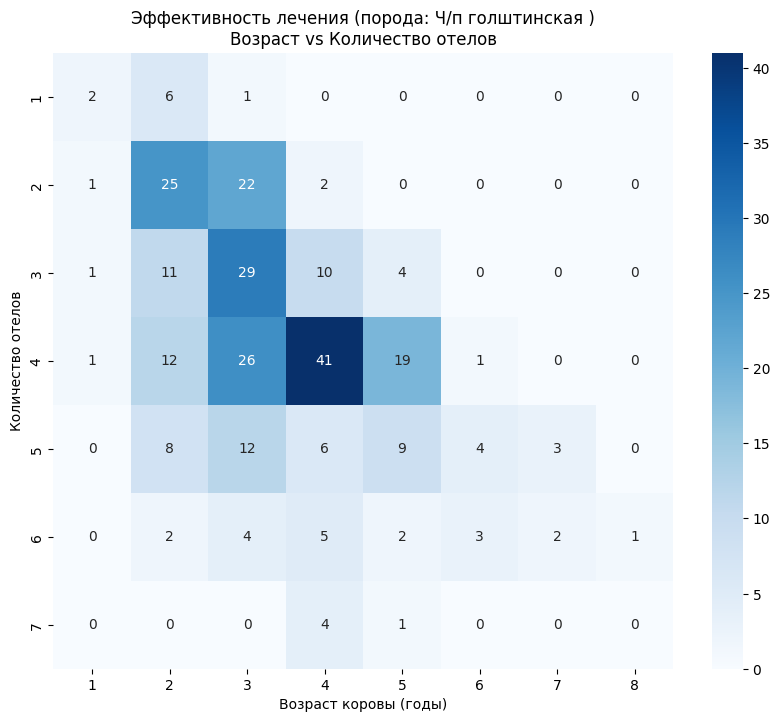

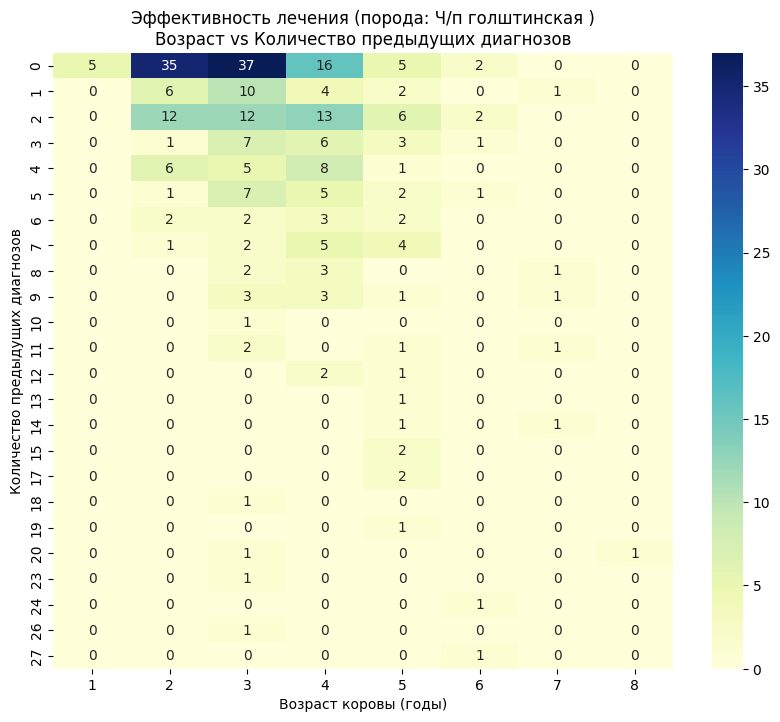

In [14]:
# Установка параметров
success_days = 14  # Интервал выздоровления в днях (по умолчанию 14 дней)
breed_threshold = 50  # Минимальное количество членов одной породы

# Сортировка данных по ID коровы и времени записи
df = df.sort_values(by=['number', 'DateAndTime'])

# Добавление флага выздоровления
df['IsHealthy'] = df['DiagName'].str.contains('здоров', case=False, na=False)

# Добавление возраста коровы на момент диагноза
df['CowAge'] = (pd.to_datetime(df['DateAndTime']) - pd.to_datetime(df['BirthDate'])).dt.days // 365

# Вычисление количества предыдущих диагнозов для каждой коровы
df['PreviousDiagnoses'] = df.groupby('number').cumcount()

# Анализ успешности лечения
success_counts = {}  # Словарь для хранения успешности схем лечения

for cow_id, group in df.groupby('number'):
    prev_treatment = None
    for i, row in group.iterrows():
        if row['IsHealthy']:
            if prev_treatment:
                success_counts[prev_treatment] = success_counts.get(prev_treatment, 0) + 1
            prev_treatment = None  # Сбрасываем текущую схему лечения
        else:
            prev_treatment = (row['breed'], row['DescriptionReport'], row['LactationNumber'], row['CowAge'], row['PreviousDiagnoses'])

# Сортировка схем лечения по успешности для каждой породы
breed_success = {}
for (breed, treatment, lactations, age, prev_diag), count in success_counts.items():
    if breed not in breed_success:
        breed_success[breed] = []
    breed_success[breed].append((treatment, count, lactations, age, prev_diag))

# Выбираем лучшие схемы лечения для каждой породы
best_treatments = {}
for breed, treatments in breed_success.items():
    treatments = sorted(treatments, key=lambda x: x[1], reverse=True)  # Сортировка по успешности
    if treatments:
        best_treatments[breed] = treatments[0][0]  # Лучшая схема лечения

# Подготовка данных для тепловых карт
heatmap_data = []
for (breed, treatment, lactations, age, prev_diag), count in success_counts.items():
    if best_treatments.get(breed) == treatment:  # Только для лучших схем лечения
        heatmap_data.append({
            'Breed': breed,
            'LactationNumber': lactations,
            'CowAge': age,
            'PreviousDiagnoses': prev_diag,
            'SuccessCount': count
        })

heatmap_df = pd.DataFrame(heatmap_data)

# Фильтрация пород по количеству записей
breed_counts = heatmap_df['Breed'].value_counts()
selected_breeds = breed_counts[breed_counts > breed_threshold].index
filtered_data = heatmap_df[heatmap_df['Breed'].isin(selected_breeds)]

# Построение тепловых карт для отфильтрованных пород
for breed in filtered_data['Breed'].unique():
    breed_data = filtered_data[filtered_data['Breed'] == breed]

    # Тепловая карта 1: Эффективность лечения от возраста и количества отелов
    pivot_1 = breed_data.pivot_table(index='LactationNumber', columns='CowAge', values='SuccessCount', aggfunc='sum', fill_value=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_1, annot=True, fmt=".0f", cmap="Blues")
    plt.title(f'Эффективность лечения (порода: {breed})\nВозраст vs Количество отелов')
    plt.xlabel('Возраст коровы (годы)')
    plt.ylabel('Количество отелов')
    plt.show()

    # Тепловая карта 2: Эффективность лечения от возраста и количества предыдущих диагнозов
    pivot_2 = breed_data.pivot_table(index='PreviousDiagnoses', columns='CowAge', values='SuccessCount', aggfunc='sum', fill_value=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_2, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f'Эффективность лечения (порода: {breed})\nВозраст vs Количество предыдущих диагнозов')
    plt.xlabel('Возраст коровы (годы)')
    plt.ylabel('Количество предыдущих диагнозов')
    plt.show()

**Выводы**<br/>
Эффективность лечения для породы "Ч/п голштинская-" от количество предыдущих диагнозов и отелов: наибольшая эффективность наблюдается для коров в возрасте от 0 до 5 лет и от 2 до 5 отелов. Максимальная эффективность: для коров возраста 3-4 лет и с 3 отелами.<br/>
<br/>
Эффективность лечения для породы "Ч/п голштинская" от количество предыдущих диагнозов и отелов: наибольшая эффективность наблюдается для коров в возрасте от 2 до 5 лет и от 2 до 5 отелов. Максимальная эффективность: для коров возраста 2-4 лет и с 4 отелами.<br/>
<br/>
Эффективность лечения для породы "Ч/п голштинская-" от количество предыдущих диагнозов и возраста: наибольшая эффективность наблюдается для коров в возрасте от 0 до 5 лет и количеством диагнозов до 9.<br/>
<br/>
Эффективность лечения для породы "Ч/п голштинская" от количество предыдущих диагнозов и возраста: наибольшая эффективность наблюдается для коров в возрасте от 0 до 5 лет и количеством диагнозов до 5.<br/>
 

<h3>Эффективность лечения для каждой породы в зависимости от количества предыдущих диагнозов</h3>

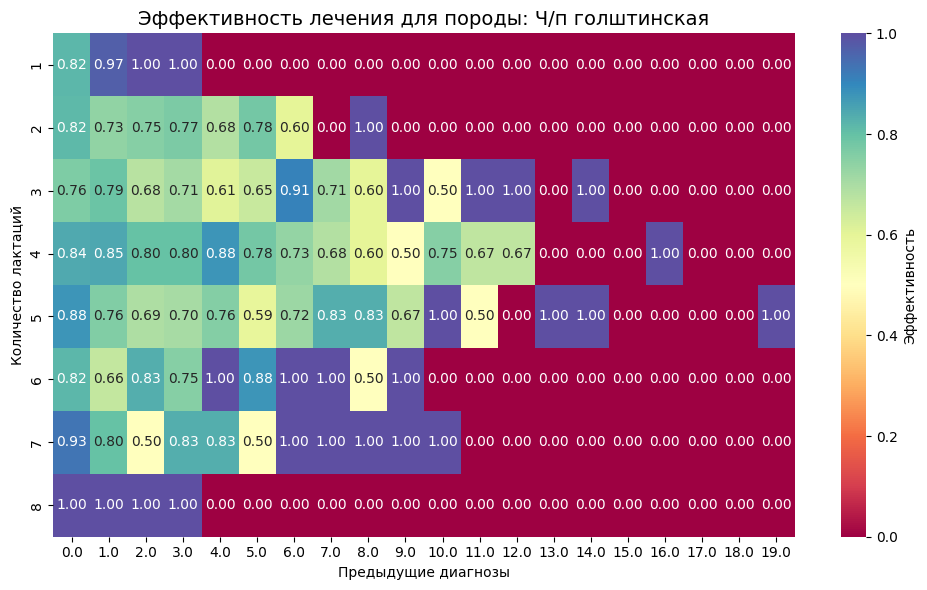

In [15]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Мастимакс", "Мастисепт", "Милоклокс"]
selected_breed = "Ч/п голштинская"  # Укажите название породы

# --- Шаг 1: Отфильтровать данные по схеме лечения ---
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)
df["breed"] = df["breed"].str.strip().str.lower()  # Привести названия пород к нижнему регистру и убрать лишние пробелы
selected_breed = selected_breed.strip().lower()  # То же самое для выбранной породы

filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Добавить столбец количества предыдущих диагнозов ---
filtered_data["PreviousDiagnoses"] = filtered_data.groupby("number")["DateAndTime"].rank(method="first") - 1

# --- Шаг 3: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 4: Построить тепловую карту для выбранной породы ---
breed_data = filtered_data[filtered_data["breed"] == selected_breed]

# Проверка наличия данных для выбранной породы
if breed_data.empty:
    print(f"Нет данных для породы: {selected_breed}")
else:
    # Создать сводную таблицу для текущей породы
    pivot_data = breed_data.pivot_table(
        values="Effective",
        index=["LactationNumber"],
        columns="PreviousDiagnoses",
        aggfunc="mean"
    ).fillna(0)

    # Построить тепловую карту
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
    plt.title(f"Эффективность лечения для породы: {selected_breed.capitalize()}", fontsize=14)
    plt.xlabel("Предыдущие диагнозы")
    plt.ylabel("Количество лактаций")
    plt.tight_layout()
    plt.show()

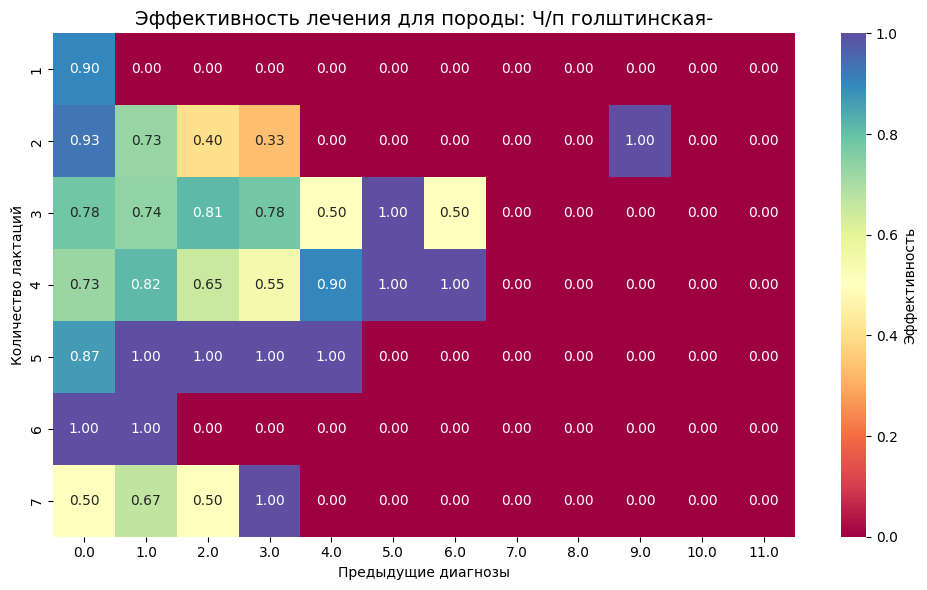

In [16]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Нитокс", "Мастиет", "Айнил"]  
selected_breed = "Ч/п голштинская-"  # Укажите название породы

# --- Шаг 1: Отфильтровать данные по схеме лечения ---
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)
df["breed"] = df["breed"].str.strip().str.lower()  # Привести названия пород к нижнему регистру и убрать лишние пробелы
selected_breed = selected_breed.strip().lower()  # То же самое для выбранной породы

filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Добавить столбец количества предыдущих диагнозов ---
filtered_data["PreviousDiagnoses"] = filtered_data.groupby("number")["DateAndTime"].rank(method="first") - 1

# --- Шаг 3: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 4: Построить тепловую карту для выбранной породы ---
breed_data = filtered_data[filtered_data["breed"] == selected_breed]

# Проверка наличия данных для выбранной породы
if breed_data.empty:
    print(f"Нет данных для породы: {selected_breed}")
else:
    # Создать сводную таблицу для текущей породы
    pivot_data = breed_data.pivot_table(
        values="Effective",
        index=["LactationNumber"],
        columns="PreviousDiagnoses",
        aggfunc="mean"
    ).fillna(0)

    # Построить тепловую карту
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
    plt.title(f"Эффективность лечения для породы: {selected_breed.capitalize()}", fontsize=14)
    plt.xlabel("Предыдущие диагнозы")
    plt.ylabel("Количество лактаций")
    plt.tight_layout()
    plt.show()

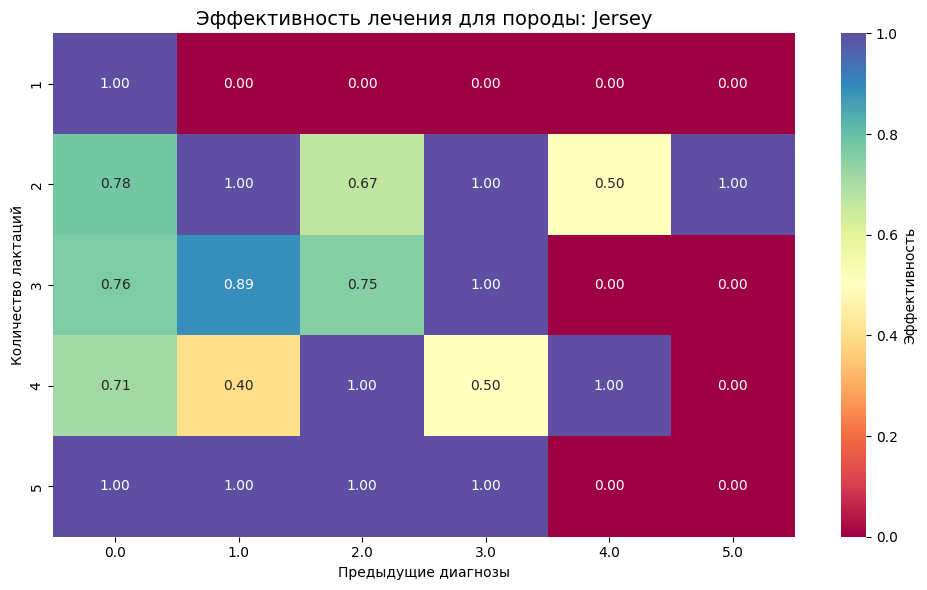

In [17]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Мастимакс", "Мастисепт", "Милоклокс"]
selected_breed = "Jersey"  # Укажите название породы

# --- Шаг 1: Отфильтровать данные по схеме лечения ---
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)
df["breed"] = df["breed"].str.strip().str.lower()  # Привести названия пород к нижнему регистру и убрать лишние пробелы
selected_breed = selected_breed.strip().lower()  # То же самое для выбранной породы

filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Добавить столбец количества предыдущих диагнозов ---
filtered_data["PreviousDiagnoses"] = filtered_data.groupby("number")["DateAndTime"].rank(method="first") - 1

# --- Шаг 3: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 4: Построить тепловую карту для выбранной породы ---
breed_data = filtered_data[filtered_data["breed"] == selected_breed]

# Проверка наличия данных для выбранной породы
if breed_data.empty:
    print(f"Нет данных для породы: {selected_breed}")
else:
    # Создать сводную таблицу для текущей породы
    pivot_data = breed_data.pivot_table(
        values="Effective",
        index=["LactationNumber"],
        columns="PreviousDiagnoses",
        aggfunc="mean"
    ).fillna(0)

    # Построить тепловую карту
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
    plt.title(f"Эффективность лечения для породы: {selected_breed.capitalize()}", fontsize=14)
    plt.xlabel("Предыдущие диагнозы")
    plt.ylabel("Количество лактаций")
    plt.tight_layout()
    plt.show()

<h3>Эффективность лечения для каждой породы в зависимости от возраста коровы</h3>

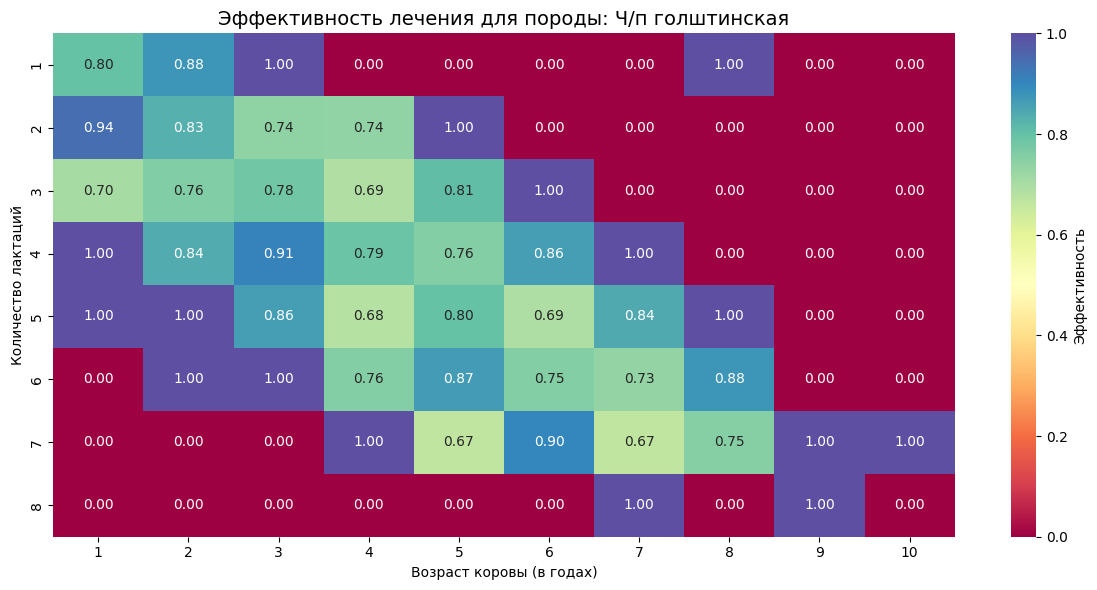

In [18]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Мастимакс", "Мастисепт", "Милоклокс"]
selected_breed = "Ч/п голштинская"  # Укажите название породы

# --- Шаг 1: Подготовка данных ---
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)
df["breed"] = df["breed"].str.strip().str.lower()  # Приведение названий пород к нижнему регистру
selected_breed = selected_breed.strip().lower()  # Приведение имени выбранной породы к нижнему регистру

# Преобразование дат
df["BirthDate"] = pd.to_datetime(df["BirthDate"])  # Убедитесь, что даты рождения корректны
df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
df["Age"] = (df["DateAndTime"] - df["BirthDate"]).dt.days // 365  # Возраст в годах

# Фильтруем данные по схемам лечения
filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 3: Построить тепловую карту для выбранной породы ---
breed_data = filtered_data[filtered_data["breed"] == selected_breed]

if breed_data.empty:
    print(f"Нет данных для породы: {selected_breed}")
else:
    # Создать сводную таблицу: ось Y - количество лактаций, ось X - возраст
    pivot_data = breed_data.pivot_table(
        values="Effective",
        index=["LactationNumber"],
        columns="Age",
        aggfunc="mean"
    ).fillna(0)

    # Построить тепловую карту
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
    plt.title(f"Эффективность лечения для породы: {selected_breed.capitalize()}", fontsize=14)
    plt.xlabel("Возраст коровы (в годах)")
    plt.ylabel("Количество лактаций")
    plt.tight_layout()
    plt.show()

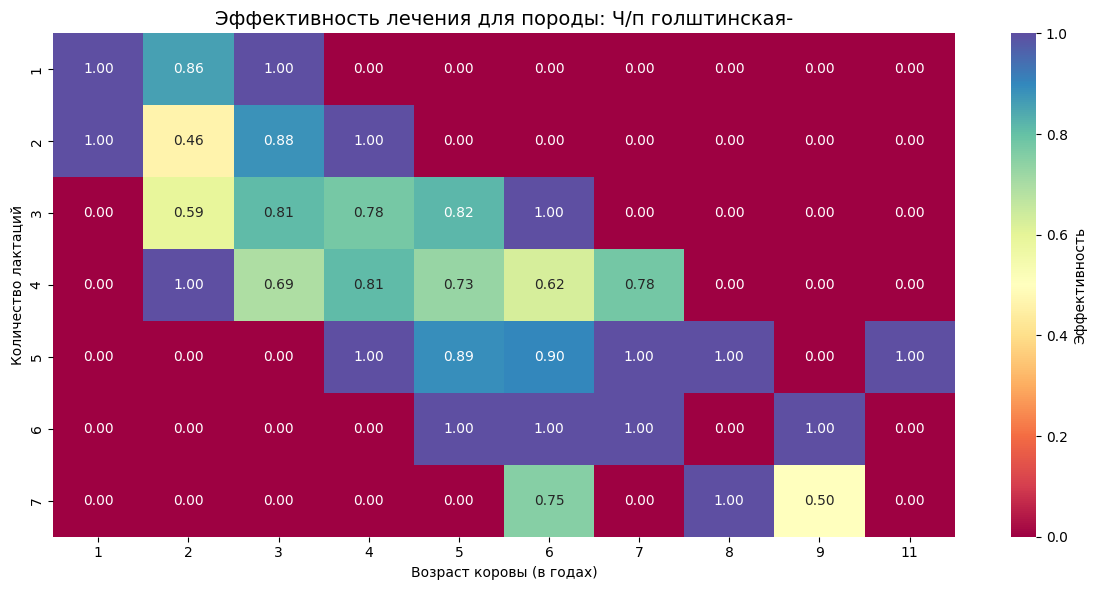

In [19]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Нитокс", "Мастиет", "Айнил"]
selected_breed = "Ч/п голштинская-"  # Укажите название породы

# --- Шаг 1: Подготовка данных ---
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)
df["breed"] = df["breed"].str.strip().str.lower()  # Приведение названий пород к нижнему регистру
selected_breed = selected_breed.strip().lower()  # Приведение имени выбранной породы к нижнему регистру

# Преобразование дат
df["BirthDate"] = pd.to_datetime(df["BirthDate"])  # Убедитесь, что даты рождения корректны
df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
df["Age"] = (df["DateAndTime"] - df["BirthDate"]).dt.days // 365  # Возраст в годах

# Фильтруем данные по схемам лечения
filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 3: Построить тепловую карту для выбранной породы ---
breed_data = filtered_data[filtered_data["breed"] == selected_breed]

if breed_data.empty:
    print(f"Нет данных для породы: {selected_breed}")
else:
    # Создать сводную таблицу: ось Y - количество лактаций, ось X - возраст
    pivot_data = breed_data.pivot_table(
        values="Effective",
        index=["LactationNumber"],
        columns="Age",
        aggfunc="mean"
    ).fillna(0)

    # Построить тепловую карту
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
    plt.title(f"Эффективность лечения для породы: {selected_breed.capitalize()}", fontsize=14)
    plt.xlabel("Возраст коровы (в годах)")
    plt.ylabel("Количество лактаций")
    plt.tight_layout()
    plt.show()

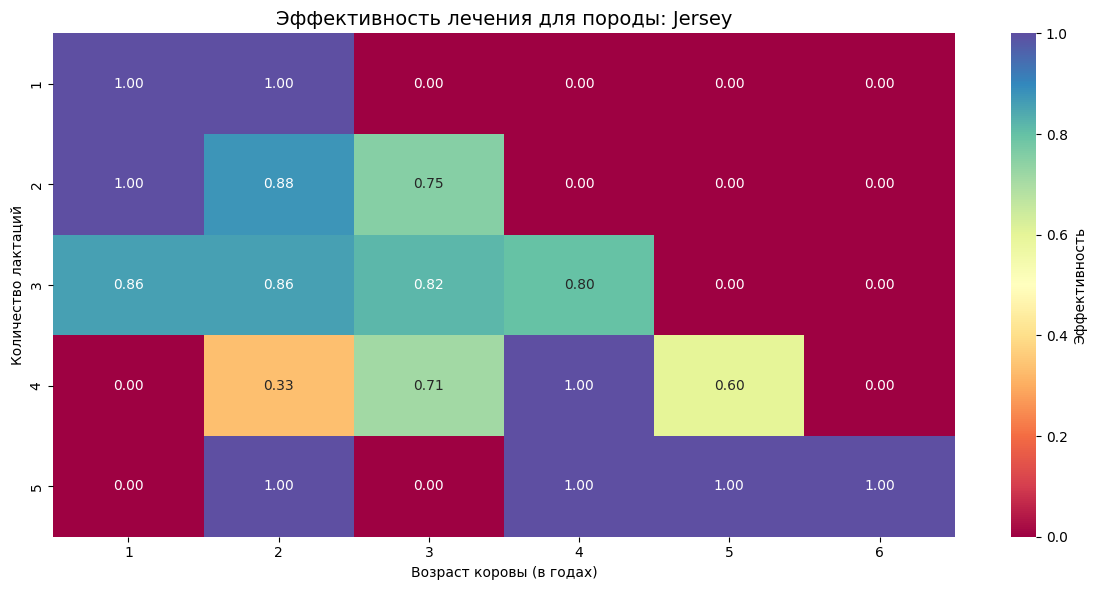

In [20]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Мастимакс", "Мастисепт", "Милоклокс"]
selected_breed = "Jersey"  # Укажите название породы

# --- Шаг 1: Подготовка данных ---
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)
df["breed"] = df["breed"].str.strip().str.lower()  # Приведение названий пород к нижнему регистру
selected_breed = selected_breed.strip().lower()  # Приведение имени выбранной породы к нижнему регистру

# Преобразование дат
df["BirthDate"] = pd.to_datetime(df["BirthDate"])  # Убедитесь, что даты рождения корректны
df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
df["Age"] = (df["DateAndTime"] - df["BirthDate"]).dt.days // 365  # Возраст в годах

# Фильтруем данные по схемам лечения
filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 3: Построить тепловую карту для выбранной породы ---
breed_data = filtered_data[filtered_data["breed"] == selected_breed]

if breed_data.empty:
    print(f"Нет данных для породы: {selected_breed}")
else:
    # Создать сводную таблицу: ось Y - количество лактаций, ось X - возраст
    pivot_data = breed_data.pivot_table(
        values="Effective",
        index=["LactationNumber"],
        columns="Age",
        aggfunc="mean"
    ).fillna(0)

    # Построить тепловую карту
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
    plt.title(f"Эффективность лечения для породы: {selected_breed.capitalize()}", fontsize=14)
    plt.xlabel("Возраст коровы (в годах)")
    plt.ylabel("Количество лактаций")
    plt.tight_layout()
    plt.show()

<h3>Логистическая регрессия поможет оценить влияние факторов на вероятность успешного лечения (Effective)</h3>

<h4>По породе Ч/п голштинская</h4>

<h4>Сбалансированы ли классы?</h4>

In [21]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Мастимакс", "Мастисепт", "Милоклокс"]
selected_breed = "Ч/п голштинская"  # Укажите название породы

# --- Шаг 1: Подготовка данных ---
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)
df["breed"] = df["breed"].str.strip().str.lower()  # Приведение названий пород к нижнему регистру
selected_breed = selected_breed.strip().lower()  # Приведение имени выбранной породы к нижнему регистру

# Преобразование дат
df["BirthDate"] = pd.to_datetime(df["BirthDate"])  # Убедитесь, что даты рождения корректны
df["DateAndTime"] = pd.to_datetime(df["DateAndTime"])
df["Age"] = (df["DateAndTime"] - df["BirthDate"]).dt.days // 365  # Возраст в годах

# Фильтруем данные по схемам лечения
filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)
filtered_data

,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName,ParsedReport,IsHealthy,CowAge,PreviousDiagnoses,Age,Effective
4875,10058,Эврика,ч/п голштинская,4,2018-12-31 16:09:45.030,2011-11-15,Клинический мастит,"Амоксицилин 15% 1 d 1X60ml Внутримышечно, Байт...",Мартыненко Г.Н,"{'Амоксицилин': '1X60ml', 'Байтрил': '1X60ml',...",False,7,4,7,1
5284,11003,Слава,ч/п голштинская,7,2019-08-04 16:08:42.347,2009-01-01,Клинический мастит,"Синулокс 5 d 1X2pcs Интрацистернально, Мастисе...",Мартыненко Г.Н,"{'Синулокс': '1X2pcs', 'Мастисепт': '1X50gm'}",False,10,7,10,1
6374,12212,Крошка,ч/п голштинская,6,2020-11-04 14:39:37.207,2012-03-17,Субклинический мастит,"Мастисепт 2 d 1X30gm Наружное, Инфларет 2 d 1X...",Винокович В.А.,"{'Мастисепт': '1X30gm', 'Инфларет': '1X15ml'}",False,8,16,8,1
6595,12212,Крошка,ч/п голштинская,6,2020-12-30 13:00:00.000,2012-03-17,Субклинический мастит,"Мастисепт 2 d 1X30gm Наружное, Инфларет 2 d 1X...",Мартыненко Г.Н,"{'Мастисепт': '1X30gm', 'Инфларет': '1X15ml'}",False,8,17,8,1
5301,12246,Ариша,ч/п голштинская,5,2019-08-08 17:15:27.217,2012-04-01,Клинический мастит,"40% раствор глюкозы 3 d 1X400ml Внутривенно, 0...",Мартыненко Г.Н,"{'40%': '1X400ml', '9%': '1X999.9ml', 'Борглюк...",False,7,4,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,211878,Крошка,ч/п голштинская,1,2024-01-18 16:00:00.000,2021-12-27,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Винокович В.А.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ...",False,2,0,2,1
10874,221004,Акация,ч/п голштинская,1,2024-09-07 10:00:00.000,2022-08-02,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Овчарова А.А.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ...",False,2,1,2,1
10766,221054,Кривая,jersey,1,2024-07-09 18:00:00.000,2022-08-11,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Овчарова А.А.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ...",False,1,0,1,1
10947,221284,Сова,jersey,1,2024-10-01 16:00:00.000,2022-09-17,Клинический мастит,"Мастигард 3 d 1X1pcs Интрацистернально, Инфлар...",Семыкин А.К.,"{'Мастигард': '1X1pcs', 'Инфларет': '1X20ml', ...",False,2,0,2,1


Распределение классов (в процентах):
Effective
1    78.611385
0    21.388615
Name: proportion, dtype: float64


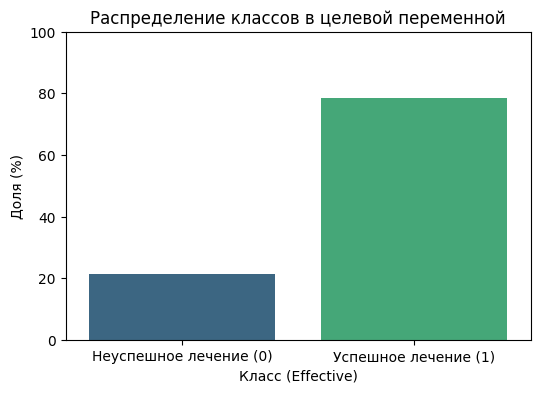

In [22]:
# Распределение классов в целевой переменной
class_distribution = filtered_data["Effective"].value_counts(normalize=True) * 100

print("Распределение классов (в процентах):")
print(class_distribution)

# Построим график для наглядности
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Распределение классов в целевой переменной")
plt.xlabel("Класс (Effective)")
plt.ylabel("Доля (%)")
plt.xticks(ticks=[0, 1], labels=["Неуспешное лечение (0)", "Успешное лечение (1)"])
plt.ylim(0, 100)
plt.show()

**Random forest - Модель**

In [24]:
# --- Шаг 1: Загрузка данных ---
# filtered_data - ваш DataFrame
df = filtered_data.copy()

# --- Шаг 2: Добавление сезона ---
df['Season'] = pd.to_datetime(df['DateAndTime']).dt.month % 12 // 3 + 1

# --- Шаг 3: Подготовка данных ---
features = ['LactationNumber', 'CowAge', 'PreviousDiagnoses', 'Season']
X = df[features]
y = df['Effective']

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Случайный лес:
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       732
           1       0.68      0.65      0.67       702

    accuracy                           0.68      1434
   macro avg       0.68      0.68      0.68      1434
weighted avg       0.68      0.68      0.68      1434

ROC-AUC: 0.75


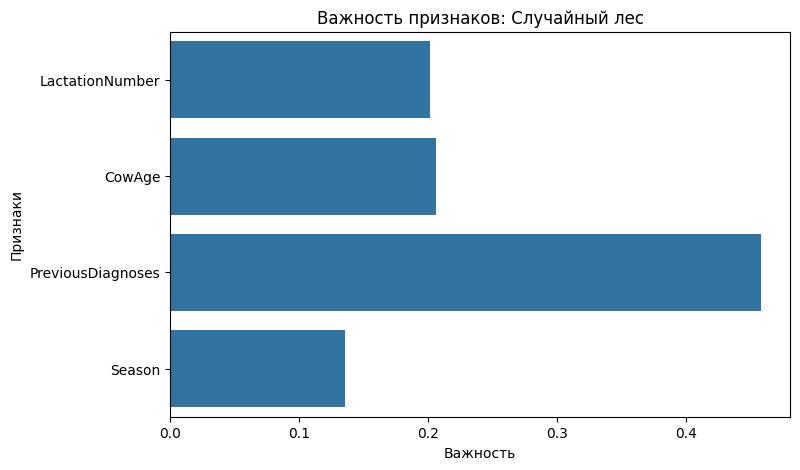

In [25]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1', verbose=1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Метрики для случайного леса
print("Случайный лес:")
print(f"Лучшие параметры: {grid_rf.best_params_}")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.2f}")

# Важность признаков для случайного леса
feature_importance_rf = best_rf.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance_rf, y=features)
plt.title("Важность признаков: Случайный лес")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.show()

Precision (точность): 0.68 означает, что из всех предсказаний "1" модель верно определяет 68%. Значение Recall 0.65 показывает, что модель находит 65% объектов класса "1".
Модель хорошо справляется с задачей классификации, показывая высокие значения ROC-AUC (0.75).
Сбалансированная производительность: Precision и Recall близки, что говорит о хорошей общей работе модели.

<h4>Выводы</h4> 
1. Эффективнсть лечения по породам, без учета доли каждой породы в общем количестве всей выборки. Наибольшую эффективнось лечения показала порода "Абердин-ангусская". 
Наименьшуж эффективность показала порода "Ч/п голшинская-".<br/>
2. Доля каждой породы от общего чиста: самая большая доля: "Ч/п голштинская". Самая наименьшая доля: "Абердин-ангусская".<br/>
Эффективность лечения по породам (средневзвешенная): Наибольшую средневзвешенную эффективность лечения показала порода "Ч/п голштинская".<br/>
3. Число случаев неэффективного лечения растет с число отелов линейно до 3 отела, потом экспоненциально падает. Падение возможно со сниженем также чила отелов после 3. <br/>
4. Для всех пород эффективность лечения экпоненциально падает с ростом количества прошлых заболеваний. <br/>
5. Для породы "Jersey" эффективность лечения падает после 6 раза заболевания (постанови диагноза). <br/>
Для породы "Голштинская" эффективность лечения падает с ростом количества отелов: начиная с 7 отела резко падает эффективность дечения. Для породы "Голштинская" эффективность лечения падает с ростом количества отелов: начиная с 7. отела резко падает эффективность дечения. Для этой породы с 10 отела дечение оказывается неэффективным независимо от 
количества предыдущих диагнзов.<br/>
Для пород: Ч/п голштинская и Jersey лучшие схемы лечения совпадают. Для породы Ч/п голштинская лучшая схема лечения отличается от лучших схем лечения для пород: Ч/п голштинская и Jersey. Это было видно из предыдущей тепловой карты. Теперь пордтвеждаем предположение подсчетом.<br/>

Для породы "Голштинская" эффективность лечения падает с ростом количества количества прощлых заболеваний: начиная с постновки 11 диагноза начинается резкий спад эффективноси лечения. <br/>
Порода "Голштинская-" менее устойчива к схемам лечения, начиная с первого отела и независимо от количества предыдущих заболевамний, относительно других пород, где явно прослеживается зависимость <br/>
эффективности лечения от количества отелов и количества предшествующих диагнозов.<br/>
8. Эффективность лучшей схемы лечения в зависимости от породы, количества лактаций и предыдущих диагнозов показывает, что  породы "Ч/п Голштинская" с 1 по 7 отел работает очень эффективно, 1 первого по 12 раз постановки диагноза. 
Также для породы "Jersey" схема работает очень эффективно  с 1 по 5 отел и с 1 по 3 раз постановки диагноза. Для породы "Ч/п Голштинская-" схема работает эффективно только, если корова болеет 1-й раз. 
Вывод: наиоучшая схема наиболее эффективна для породы: "Ч/п Голштинская".<br/>
<br/>
Эффективность лечения для породы "Ч/п голштинская-" от количество предыдущих диагнозов и отелов: наибольшая эффективность наблюдается для коров в возрасте от 0 до 5 лет и от 2 до 5 отелов. Максимальная эффективность: для коров возраста 3-4 лет и с 3 отелами.<br/>
<br/>
Эффективность лечения для породы "Ч/п голштинская" от количество предыдущих диагнозов и отелов: наибольшая эффективность наблюдается для коров в возрасте от 2 до 5 лет и от 2 до 5 отелов. Максимальная эффективность: для коров возраста 2-4 лет и с 4 отелами.<br/>
<br/>
Эффективность лечения для породы "Ч/п голштинская-" от количество предыдущих диагнозов и возраста: наибольшая эффективность наблюдается для коров в возрасте от 0 до 5 лет и количеством диагнозов до 9.<br/>
<br/>
Эффективность лечения для породы "Ч/п голштинская" от количество предыдущих диагнозов и возраста: наибольшая эффективность наблюдается для коров в возрасте от 0 до 5 лет и количеством диагнозов до 5.<br/>
<br/>
Предсказываем эффективность лечения коровы в зависимости от: Возраста коровы, сезона заболевания, числа отелов, количества прошлых диагнозов.<br>
Модель: Случайный лес. <br/>
Precision (точность): 0.68 означает, что из всех предсказаний "1" модель верно определяет 68%. Значение Recall 0.65 показывает, что модель находит 65% объектов класса "1".<br/>
Модель хорошо справляется с задачей классификации, показывая высокие значения ROC-AUC (0.75).<br/>
Сбалансированная производительность: Precision и Recall близки, что говорит о хорошей общей работе модели.<br/>